[0.737 4.853]
44100
(214016, 2)


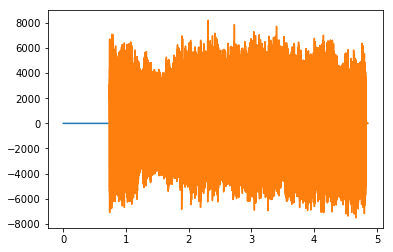

In [1]:
import wave, numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

# readfile
fs,x_wave = wavfile.read("file_11.wav")
interval = np.genfromtxt('file_11.txt', delimiter='\t')
print(interval)

print(fs)
x = x_wave.astype(float)
x_play = x.astype(int)


print(x.shape)
bb,ee = int(interval[0]*fs),int(interval[1]*fs)

sd.play(x_play,fs,blocking=True)


plt.plot(np.linspace(start=0,stop=(x_play.shape[0]/fs),num=x_play.shape[0]),\
        np.linspace(start=0,stop=0,num=x_play.shape[0]))
plt.plot(np.linspace(start=interval[0],stop=interval[1],num=int((interval[1]-interval[0])*fs)),\
        x_play[bb:ee,0])
plt.show()

(129, 955)


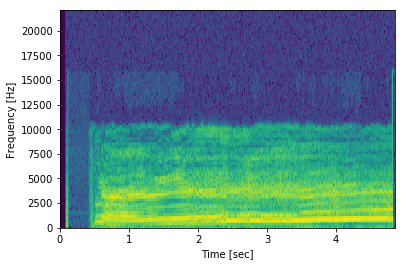

64561.34106283819
146 955


In [88]:
# spectrogram
f, t, Sxx = signal.spectrogram(x[:,0], fs,window=("hann"))
print(Sxx.shape)
plt.pcolormesh(t, f, np.log(Sxx+1e-8))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(Sxx.max())

#Sxx /= Sxx.max()
#Sxx = -np.log(Sxx+1e-9)
Sxx /= Sxx.max()
#Sxx  = 1-Sxx
t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
t_ee= int(t.shape[0]*ee/x_play.shape[0])
print(t_bb,t_ee)


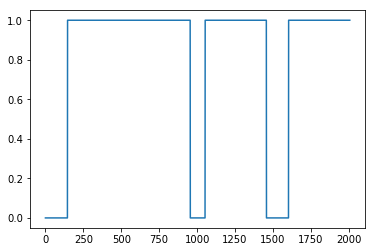

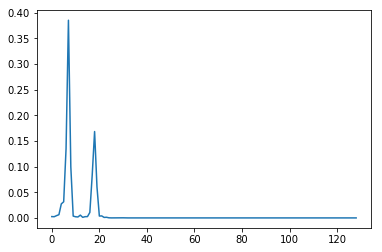

In [89]:
# laybel_gen - 0 is everything else, 1 is scream class
labels = np.zeros(Sxx.shape[1])
for i in range(t_bb,t_ee):
    labels[i] = 1

for i in range(0,len(labels)):
    labels[i] = int(labels[i])
Sxx = np.hstack((Sxx,0.7*Sxx[:,int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],0.8*Sxx[:,0:t_bb+int((t_ee-t_bb)/2)]))
labels = np.hstack((labels,labels[int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],labels[0:t_bb+int((t_ee-t_bb)/2)]))
plt.plot(labels)
plt.show()
plt.plot(Sxx.T[t_bb-1])
plt.show()

In [90]:
#from RNNbiDir import *
from LSTMSingle import *
#from RNNSingle import *

In [96]:
epoch = 30*1000;
Sxx_in = Sxx.T

lenIn, lenOut, lenRec = Sxx_in.shape[1],2, int(Sxx_in.shape[0]/10)
sizeHidden, numHiddenLayer = 50,1;
learningRate = 0.3;

R = myRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate)

0 err: -0.693147178559943


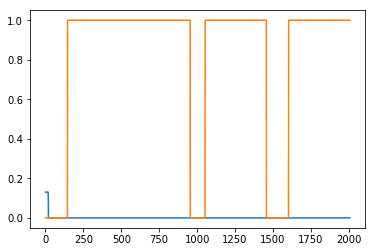

113 err: -0.16549443530493022


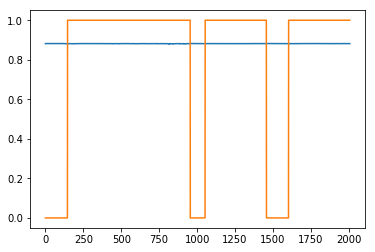

226 err: -0.02655230519765314


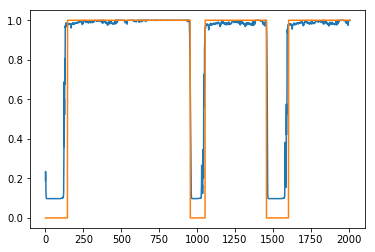

339 err: -0.0002897872914572428


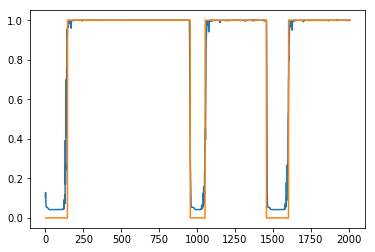

452 err: -0.0014581326986492938


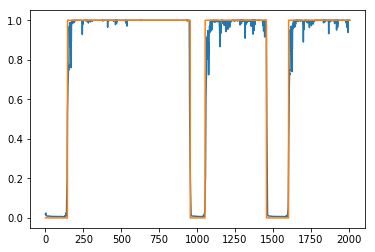

565 err: -0.14142032267919796


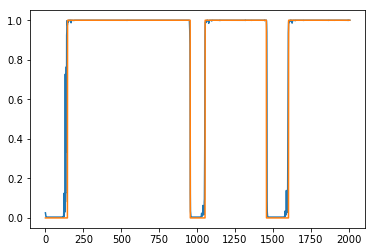

KeyboardInterrupt: 

In [97]:
# training
n,position = 0,0;
while n<epoch:
    
    if(position+lenRec+1 >= Sxx.shape[1] or n == 0):
        R.h = np.zeros_like(R.h)
        R.c = np.zeros_like(R.c)
        position = 0;
        
    inputs  = Sxx_in[position:position+lenRec]
    targets  = labels[position:position+lenRec]

    R.update_inputs_targets(inputs,targets)
    R.fwd_pass();
    
    err = R.bwd_pass();
    
    if(n%113 == 0 ): # 113 is a prime number
        print(n,"err:",err)
        
        result = [];
        compare = [];
        ps = int((n**2)%Sxx_in.shape[0])
        ps = np.clip(ps,0,Sxx_in.shape[0]-2*lenRec-1)
        ps = 0 
        for i in range(0,Sxx_in.shape[0]):
            infer_in_enc = Sxx_in[ps+i]
            
            ret = R.get_prob(infer_in_enc)
            #plt.plot(R.x)
            #plt.plot(R.h)
            #plt.show()
            #print(i,":",ret)
            #result.append(str(ret))
            #compare.append(str(int(labels[ps+i])))
            result.append(ret)
            compare.append(labels[ps+i])
            
        #res_concat = ''.join(result )
        #comp_concat = ''.join(compare)
        #print(ps,",",ps+lenRec)
        #print("output",res_concat)
        #print("actual",comp_concat+'\n')
        plt.plot(result)
        plt.plot(compare)
        plt.show()
    position += lenRec;
    n += 1;

In [ ]:
print(R.targets[0])